# Random Forest

In [2]:
import pandas as pd

# Path to data file
parquet_file_path = '../../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/en_clean_gee_data.parquet'

# Load into a DataFrame
df = pd.read_parquet(parquet_file_path)

# Display head
df.head()

,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,...,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness,Forest_Presence
9,2902,11605,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.799771,68.0,332.15,0.393728,298.85,0.927410,1323.685053,-0.006312,Present
12,2902,11608,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,8129.0,0.796553,68.0,332.15,0.423713,298.85,2.935819,1323.685053,-0.014932,Present
13,2902,11609,Wetlands,Vegetation,Herbaceous plants,Grasses,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.644415,65.0,340.45,0.380250,304.70,0.944368,1323.685053,-0.001697,Present
15,2902,11611,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,8129.0,0.784331,68.0,332.15,0.512687,298.85,0.927410,1323.685053,-0.027987,Present
16,2902,11612,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.769357,65.0,340.45,0.360428,304.70,2.645556,1323.685053,-0.009912,Present


In [3]:
# Check for columns with missing values
missing_columns = df.columns[df.isnull().any()]

# Display the results
print("Columns with missing values:", missing_columns)

Columns with missing values: Index([], dtype='object')


In [4]:
print(df.columns.tolist())

['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry', 'BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect', 'aspectcos', 'aspectdeg', 'aspectsin', 'brightness', 'clay_1mMed', 'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed', 'savi', 'silt_1mMed', 'slope', 'topDiv', 'wetness', 'Forest_Presence']


In [5]:
y = df['Use']  # Set the target variable
X = df[['BLUE','GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect',
       'aspectcos', 'aspectdeg', 'brightness', 'clay_1mMed',
       'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi',
       'ocs_1mMed', 'sand_1mMed', 'savi', 'slope', 'topDiv',
       'wetness']]  # Predictor features


In [6]:
print(y.unique())

['Wetlands' 'Grasslands' 'Other classes' 'Forest' 'Agriculture'
 'Forest plantation' 'No information' 'Not_Applicable']


In [7]:
# check for imbalance
print("\nClass distribution:")
print(y.value_counts(normalize=True))


Class distribution:
Use
Forest               0.573300
Grasslands           0.237094
Agriculture          0.084957
Other classes        0.051481
Wetlands             0.039808
Forest plantation    0.009117
No information       0.002383
Not_Applicable       0.001860
Name: proportion, dtype: float64


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Cross-validation

In [11]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Splits our data into 5 folds, training on 4 parts and testing on 1
cv_scores = cross_val_score(
    rf, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy' # use stratified folds to keep class balance in each split
)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation scores: [0.81634596 0.8144421  0.81804583 0.81612947 0.8125935 ]
Mean CV accuracy: 0.8155 ± 0.0019


# Hyperparameter tuning with GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create a grid of different model settings to try
param_grid = {
    'n_estimators': [100, 200], # number of trees
    'max_depth': [None, 20],    # max tree depth
    'min_samples_split': [2, 5] 
}

# GridSearchCV tries all possible combinations
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=3),
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8080


# Train model with best parameters

In [13]:
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [14]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = best_rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.8254
Classification Report:
                   precision    recall  f1-score   support

      Agriculture       0.88      0.69      0.78      1562
           Forest       0.86      0.94      0.90     10539
Forest plantation       1.00      0.18      0.31       168
       Grasslands       0.72      0.74      0.73      4359
   No information       0.50      0.02      0.04        44
   Not_Applicable       1.00      0.18      0.30        34
    Other classes       0.77      0.42      0.55       946
         Wetlands       0.90      0.75      0.82       732

         accuracy                           0.83     18384
        macro avg       0.83      0.49      0.55     18384
     weighted avg       0.83      0.83      0.82     18384



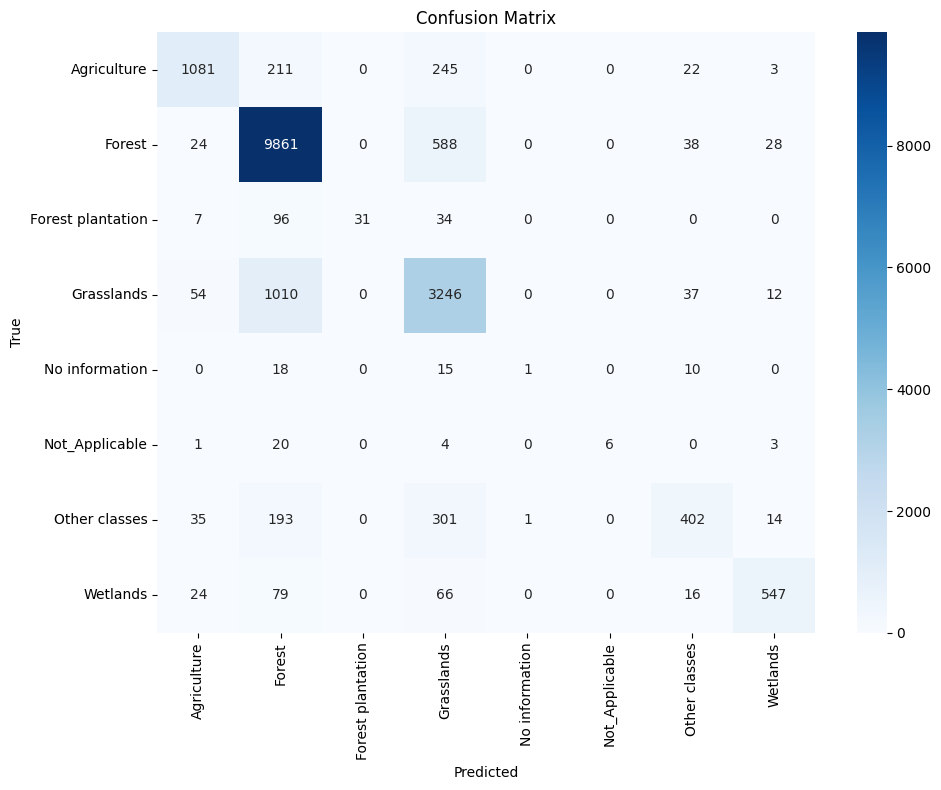

In [15]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Try PCA to reduce dimensionality

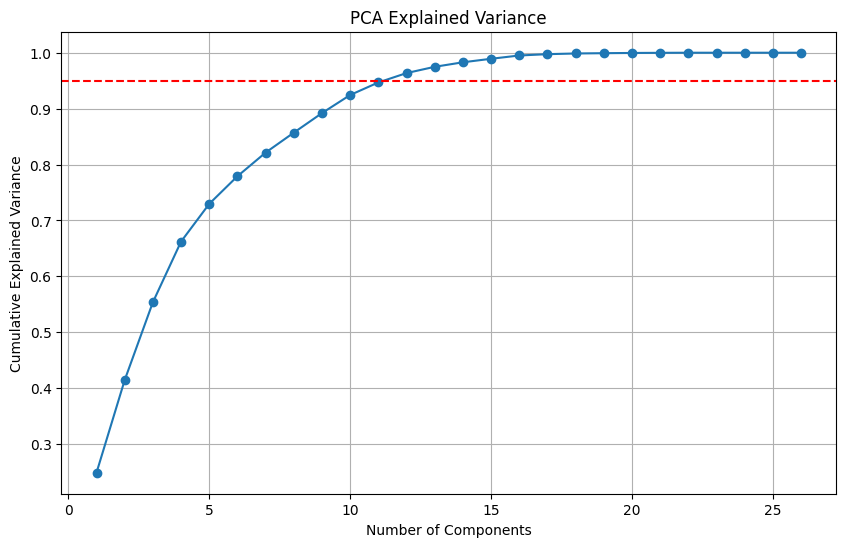

In [16]:
from sklearn.decomposition import PCA

# PCA finds the components where our data varies the most
# Helps decide how many features we actually need to keep
pca = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()
# X-axis: number of components used
# Y-axis: percentage of total variance explained
# Red line: 95% variance threshold
# Blue line: Shows how quickly we capture information as we add more components

In [17]:
# Determine number of components for 95% variance
n_components = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Number of components for 95% variance: {n_components}") # From 26 -> 12

Number of components for 95% variance: 12


In [18]:
# Create a pipeline with PCA and Random Forest
from sklearn.pipeline import Pipeline

pca_rf_pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('rf', RandomForestClassifier(**grid_search.best_params_, random_state=42))
])

# Train and evaluate the PCA + RF pipeline
pca_rf_pipeline.fit(X_train_scaled, y_train)
pca_rf_accuracy = pca_rf_pipeline.score(X_test_scaled, y_test)
print(f"\nPCA + RF Test Accuracy: {pca_rf_accuracy:.4f}")


PCA + RF Test Accuracy: 0.7887


In [19]:
# Compare with the standard RF
print(f"Standard RF Test Accuracy: {accuracy:.4f}")

Standard RF Test Accuracy: 0.8254


In [ ]:
# Save the model
# import joblib
# joblib.dump(best_rf, 'best_rf_model.pkl')
# print("Random Forest model saved as 'best_rf_model.pkl'")

Random Forest model saved as 'best_rf_model.pkl'
